In [199]:
# SETUP

from pandas.io import sql
import pymysql as mdb
from datetime import datetime
import random
import numpy as np
import pandas as pd
from brickset import *
from scipy import stats, integrate
from amazonproduct import API
from bs4 import BeautifulSoup
import lxml
import matplotlib.pyplot as plt
import urllib2
from bs4 import BeautifulSoup
import itertools
import time
from time import mktime
import re
import seaborn
import math


In [200]:
# Load and clean up the data

fn = '/Users/sharathbennur/Insights/Project/legoSet.pkl'
legos = pd.read_pickle(fn)
legos.shape

k,v = legos.shape
priceA = np.empty((k,1))
price3 = np.empty((k,1))
wi = np.empty((k,1))
hi = np.empty((k,1))
HpriceA = np.empty((k,1))
pie = np.empty((k,1))
ASINs = []
introD = []
sellOD = []
hpDA = []
introY = []

for I in range(0,k):
    price3[I] = float(legos.loc[I,"currentPrice_3"])
    priceA[I] = float(legos.loc[I,"currentPrice_A"])
    wi[I] = float(legos.loc[I,"want_it"])
    hi[I] = float(legos.loc[I,"have_it"])
    pie[I] = float(legos.loc[I,"pieces"])
    ASINs.append(str(legos.loc[I,"ASIN"]))
    introD.append(str(legos.loc[1,"introDate"]))
    hpDA.append(str(legos.loc[I,"highPriceDate_A"]))
    sellOD.append(str(legos.loc[I,"selloutDate"]))
    introY.append(str(legos.loc[I,"introYear"]))

legos["ASIN"] = ASINs
legos["currentPrice_3"] = price3
legos["currentPrice_A"] = priceA
legos["want_it"] = wi
legos["have_it"] = hi
legos["pieces"] = pie
legos["introDate_S"] = introD
legos["highPriceDate_A_S"] = hpDA
legos["selloutDate_S"] = sellOD
legos["introYear_S"] = introY
legos["minifigs"] = legos["minifigs"].fillna(0)


detectSlash = re.compile(ur'^\d*\.?\d*')
rp = np.empty((k,1))
for I in range(0,k):
    try:
        rp[I] = float(legos.loc[I,"retailPrice"])
    except (UnicodeEncodeError, ValueError):
        price = legos.loc[I,"retailPrice"]
        price = price.encode("utf-8")
        price1 = re.search(detectSlash,price)
        price2 = price1.group(0)
        price3 = re.sub('[^a-zA-Z0-9-_*.]', '', price2)
        try:
            rp[I] = float(price3)
        except ValueError : # if there is a value error due to the GBP symbol
            print "passing"

legos["retailPrice"] = rp

legos.dtypes

SetNumber                    object
SetName                      object
Theme                        object
ASIN                         object
retailPrice                 float64
currentPrice_A              float64
highPrice_A                 float64
lowPrice_A                  float64
avgPrice_A                  float64
highPrice_3                 float64
lowPrice_3                  float64
avgPrice_3                  float64
introDate            datetime64[ns]
introYear                    object
selloutDate                  object
highPriceDate_A              object
pieces                      float64
minifigs                    float64
rating_B                    float64
want_it                     float64
have_it                     float64
currentPrice_3              float64
introDate_S                  object
highPriceDate_A_S            object
selloutDate_S                object
introYear_S                  object
dtype: object

In [201]:
# Setting up the time variables
from sklearn.preprocessing import Imputer

# First "time to now", to get total appreciation in price
legos["time_to_now"]=""
legos["time_to_sellout"]=""
k,v = legos.shape
time_to_now = np.empty((k,1))
time_to_sellout = np.empty((k,1))
today=datetime.today()

# sanity check to make sure all the dates are the correct format
for I in legos.index:
    try:
        time_to_now[I] = (today - legos.loc[I,"introDate"]).days
    except:
        pass

legos["time_to_now"] = time_to_now

# Then "time_to_sellout" with imputing missing values
for I in legos.index:
    if isinstance(legos.loc[I,"selloutDate"], datetime):
        try:
            time_to_sellout[I] = (legos.loc[I,"selloutDate"] - legos.loc[I,"introDate"]).days
        except:
            pass
    elif math.isnan(legos.loc[I,"selloutDate"]):
        time_to_sellout[I] = 0

imp = Imputer(missing_values=0,strategy='median')
time_to_sellout = imp.fit_transform(time_to_sellout)

legos["time_to_sellout"] = time_to_sellout
legos["desirability"] = legos["want_it"]/legos["have_it"]


In [202]:
print legos.loc[0,"currentPrice_A"]
legos_backup = legos

79.0


In [203]:
print legos.loc[0,"selloutDate"]
print math.isnan(legos.loc[0,"selloutDate"])
print legos.loc[0,"introDate"]
# get time to sellout
# legos.loc[0,"selloutDate"] - legos.loc[0,"introDate"]

nan
True
2015-09-04 00:00:00


In [204]:
print time_to_now[0]
print time_to_sellout[0]
print legos.SetName[0]
print len(time_to_now)
print len(time_to_sellout)
print legos.shape

[ 24.]
[ 624.]
LEGO Star Wars Poe's X-Wing Fighter 75102 Building Kit
4832
4832
(4832, 29)


In [205]:
# Maximum Price Increase Prediction
legos["maxPredictedRise_3"] = legos["highPrice_3"]/legos["retailPrice"]
legos["maxPredictedRise_A"] = legos["highPrice_A"]/legos["retailPrice"]

# Average Price Increase Prediction
legos["avgPredictedRise_3"] = legos["avgPrice_3"]/legos["retailPrice"]
legos["avgPredictedRise_A"] = legos["avgPrice_A"]/legos["retailPrice"]

# convert maxPredictedRise_3 into a perday measure
legos["maxPredictedRise_3perDay"] = legos["maxPredictedRise_3"]/legos["time_to_now"]
legos["avgPredictedRise_3perDay"] = legos["avgPredictedRise_3"]/legos["time_to_now"]

# print maxPredictedRise_3_Filter
# print legos
print legos.maxPredictedRise_3perDay.min()
maxPredictedRise_3perDay =  legos.maxPredictedRise_3perDay
maxPredictedRise_3perDay.replace(np.inf,np.nan, inplace=True)
print maxPredictedRise_3perDay.max()

0.000327689724316
0.350667897523


In [206]:
# Computed Features & Predictors
# filter and keep only what I have data for
maxPredictedRise_3perDay_Filter = legos['maxPredictedRise_3perDay']<0.1
legos = legos[maxPredictedRise_3perDay_Filter]
%matplotlib inline
print legos.maxPredictedRise_3perDay.min()
maxPredictedRise_3perDay =  legos.maxPredictedRise_3perDay
maxPredictedRise_3perDay.replace(np.inf,np.nan, inplace=True)
print maxPredictedRise_3perDay.max()
legos.shape

0.000327689724316
0.0975390156062


(919, 35)

(array([ 480.,  145.,  101.,   63.,   35.,   31.,   14.,   12.,    6.,
           6.,    8.,    4.,    3.,    1.,    4.,    3.,    0.,    2.,
           0.,    1.]),
 array([  0.32637897,   3.22781002,   6.12924107,   9.03067212,
         11.93210317,  14.83353422,  17.73496528,  20.63639633,
         23.53782738,  26.43925843,  29.34068948,  32.24212053,
         35.14355159,  38.04498264,  40.94641369,  43.84784474,
         46.74927579,  49.65070684,  52.5521379 ,  55.45356895,  58.355     ]),
 <a list of 20 Patch objects>)

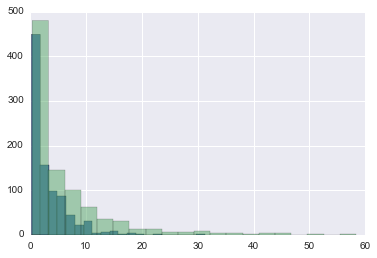

In [207]:
avgPredictedRise_3perDay = legos["avgPredictedRise_3"].values
maxPredictedRise_3perDay = legos["maxPredictedRise_3"].values

plt.hist(avgPredictedRise_3perDay, bins=20)
plt.hist(maxPredictedRise_3perDay, bins=20,alpha=0.5)

(array([ 480.,  145.,  101.,   63.,   35.,   31.,   14.,   12.,    6.,
           6.,    8.,    4.,    3.,    1.,    4.,    3.,    0.,    2.,
           0.,    1.]),
 array([  0.32637897,   3.22781002,   6.12924107,   9.03067212,
         11.93210317,  14.83353422,  17.73496528,  20.63639633,
         23.53782738,  26.43925843,  29.34068948,  32.24212053,
         35.14355159,  38.04498264,  40.94641369,  43.84784474,
         46.74927579,  49.65070684,  52.5521379 ,  55.45356895,  58.355     ]),
 <a list of 20 Patch objects>)

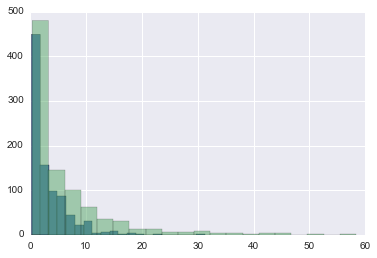

In [208]:
# legos["avgPredictedRise_3"] = legos["avgPredictedRise_3"] < 100
avgPredictedRise_3 = legos["avgPredictedRise_3"].values
maxPredictedRise_3 = legos["maxPredictedRise_3"].values

plt.hist(avgPredictedRise_3, bins=20)
plt.hist(maxPredictedRise_3, bins=20,alpha=0.5)

(array([   0.,    0.,    0.,    0.,    1.,    8.,   72.,   99.,  115.,
          59.,   45.,   34.,   21.,   23.,   17.,   21.,   16.,   13.,
          13.,   13.]),
 array([-1. , -0.7, -0.4, -0.1,  0.2,  0.5,  0.8,  1.1,  1.4,  1.7,  2. ,
         2.3,  2.6,  2.9,  3.2,  3.5,  3.8,  4.1,  4.4,  4.7,  5. ]),
 <a list of 20 Patch objects>)

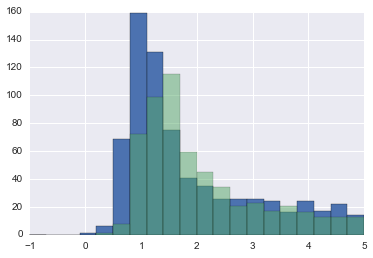

In [209]:
avgPredictedRise_3 = legos["avgPredictedRise_3"].values
maxPredictedRise_3 = legos["maxPredictedRise_3"].values

plt.hist(avgPredictedRise_3, bins=20, range=(-1, 5))
plt.hist(maxPredictedRise_3, bins=20, range=(-1, 5),alpha=0.5)

(array([   0.,    0.,    0.,    0.,    0.,    0.,  216.,   33.,   10.,
           2.,    3.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.]),
 array([-1. , -0.7, -0.4, -0.1,  0.2,  0.5,  0.8,  1.1,  1.4,  1.7,  2. ,
         2.3,  2.6,  2.9,  3.2,  3.5,  3.8,  4.1,  4.4,  4.7,  5. ]),
 <a list of 20 Patch objects>)

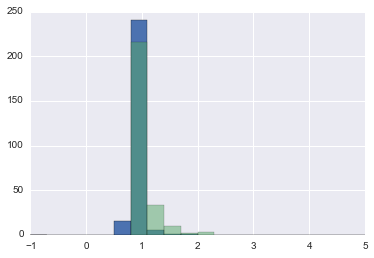

In [210]:
avgPredictedRise_A = legos["avgPredictedRise_A"].values
maxPredictedRise_A = legos["maxPredictedRise_A"].values

plt.hist(avgPredictedRise_A, bins=20, range=(-1, 5))
plt.hist(maxPredictedRise_A, bins=20, range=(-1, 5),alpha=0.5)

## 3rd Party Price Increase Analysis

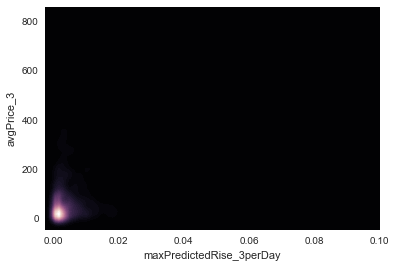

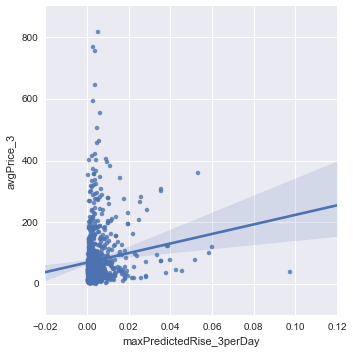

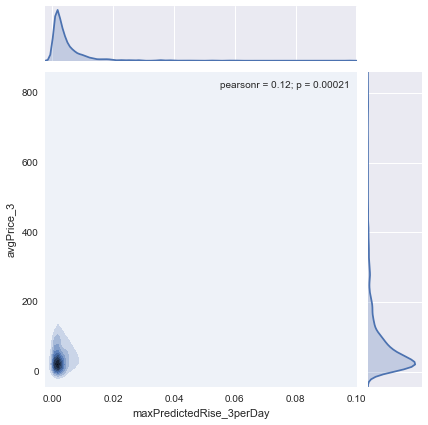

In [211]:
cmap = seaborn.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
seaborn.kdeplot(legos.maxPredictedRise_3perDay, legos.avgPrice_3, cmap=cmap, n_levels=60, shade=True);

seaborn.lmplot(x="maxPredictedRise_3perDay", y="avgPrice_3", data=legos);
seaborn.jointplot(x="maxPredictedRise_3perDay", y="avgPrice_3", data=legos, kind="kde");


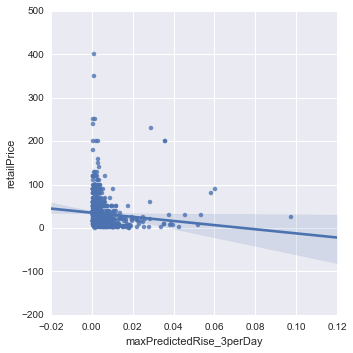

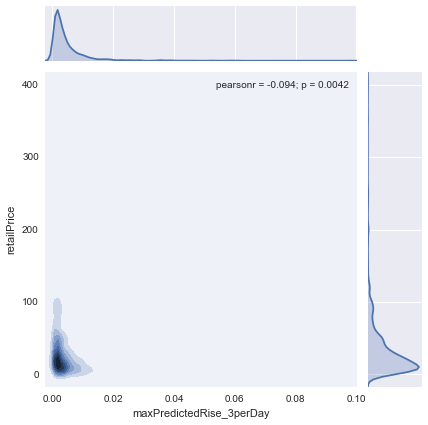

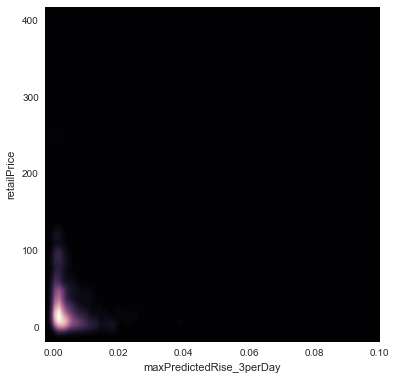

In [212]:
seaborn.lmplot(x="maxPredictedRise_3perDay", y="retailPrice", data=legos);
seaborn.jointplot(x="maxPredictedRise_3perDay", y="retailPrice", data=legos, kind="kde");

f, ax = plt.subplots(figsize=(6, 6))
cmap = seaborn.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
seaborn.kdeplot(legos.maxPredictedRise_3perDay, legos.retailPrice, cmap=cmap, n_levels=60, shade=True);

In [213]:
# np.unique(legos["Theme"])

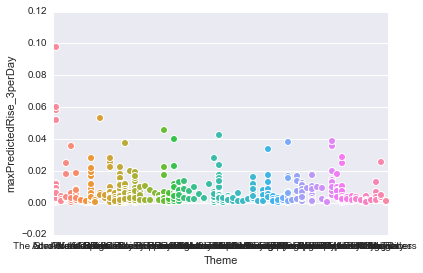

In [214]:
Theme = legos["Theme"]
seaborn.stripplot(x="Theme", y="maxPredictedRise_3perDay", data=legos);

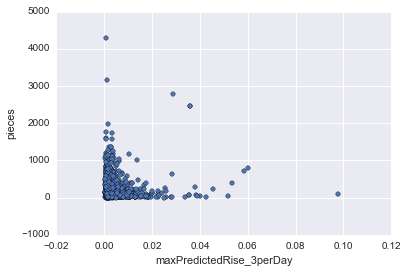

In [215]:
legos.plot(kind='scatter',x='maxPredictedRise_3perDay',y='pieces')

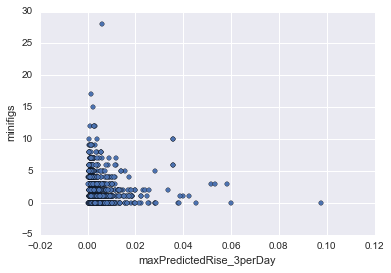

In [216]:
legos.plot(kind='scatter',x='maxPredictedRise_3perDay',y='minifigs')


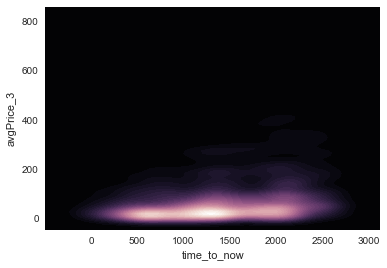

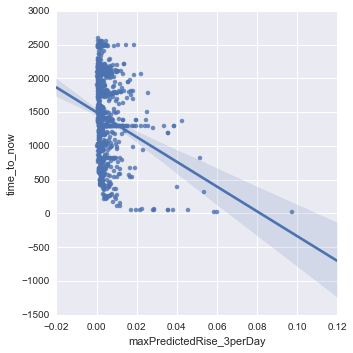

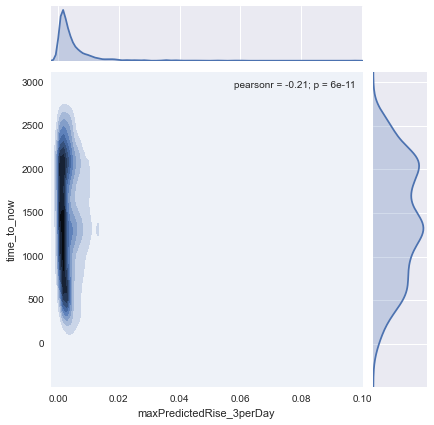

In [217]:
cmap = seaborn.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
seaborn.kdeplot(legos.time_to_now, legos.avgPrice_3, cmap=cmap, n_levels=60, shade=True);

seaborn.lmplot(x="maxPredictedRise_3perDay", y="time_to_now", data=legos);
seaborn.jointplot(x="maxPredictedRise_3perDay", y="time_to_now", data=legos, kind="kde");


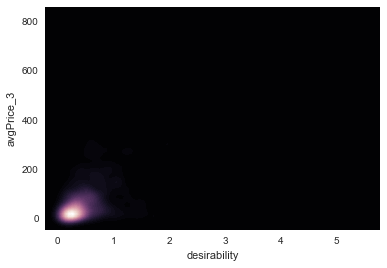

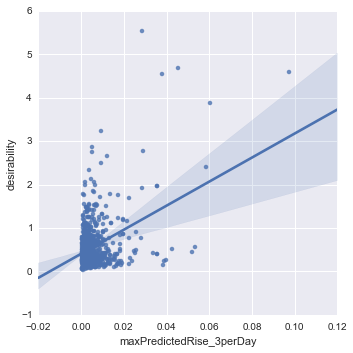

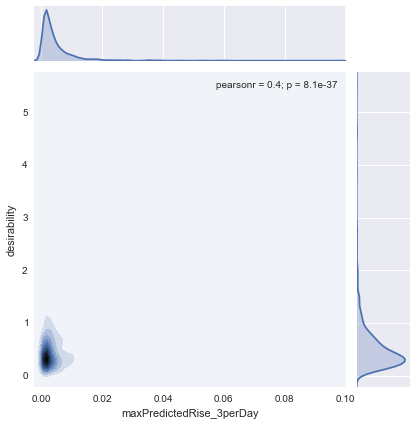

In [218]:
cmap = seaborn.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
seaborn.kdeplot(legos.desirability, legos.avgPrice_3, cmap=cmap, n_levels=60, shade=True);

seaborn.lmplot(x="maxPredictedRise_3perDay", y="desirability", data=legos);
seaborn.jointplot(x="maxPredictedRise_3perDay", y="desirability", data=legos, kind="kde");


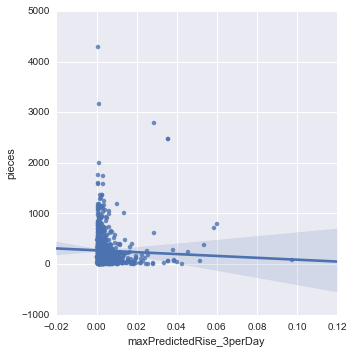

In [219]:
# NOT WORKING FOR NOW ###
import matplotlib as mpl
import matplotlib.pyplot as plt

seaborn.lmplot(x="maxPredictedRise_3perDay", y="pieces", data=legos);

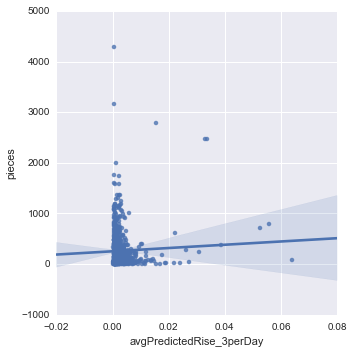

In [220]:
seaborn.lmplot(x="avgPredictedRise_3perDay", y="pieces", data=legos);

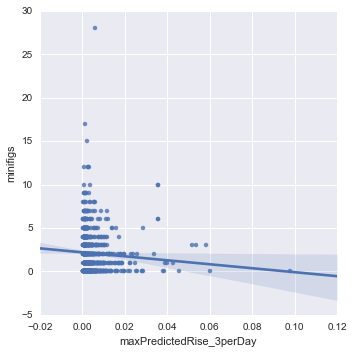

In [221]:
seaborn.lmplot(x="maxPredictedRise_3perDay", y="minifigs", data=legos);

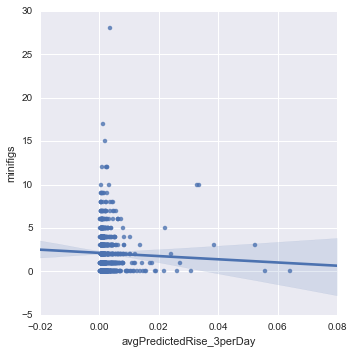

In [222]:
seaborn.lmplot(x="avgPredictedRise_3perDay", y="minifigs", data=legos);

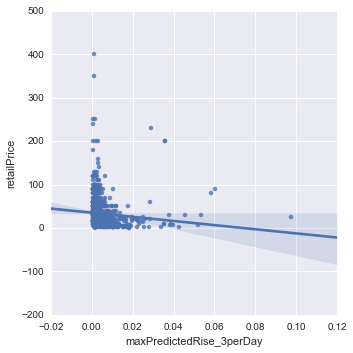

In [223]:
seaborn.lmplot(x="maxPredictedRise_3perDay", y="retailPrice", data=legos);

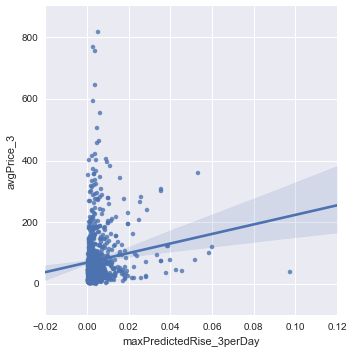

In [224]:
seaborn.lmplot(x="maxPredictedRise_3perDay", y="avgPrice_3", data=legos);

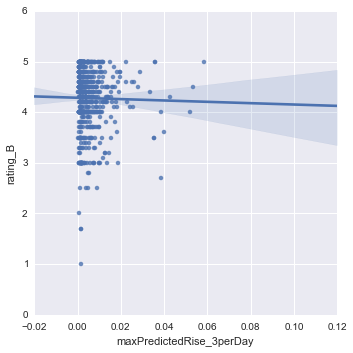

In [225]:
seaborn.lmplot(x="maxPredictedRise_3perDay", y="rating_B", data=legos);

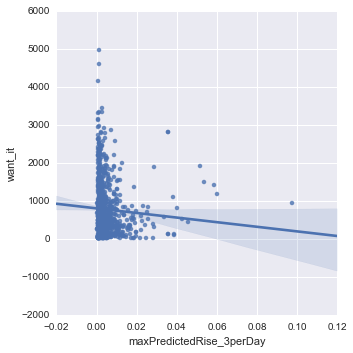

In [226]:
seaborn.lmplot(x="maxPredictedRise_3perDay", y="want_it", data=legos);

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


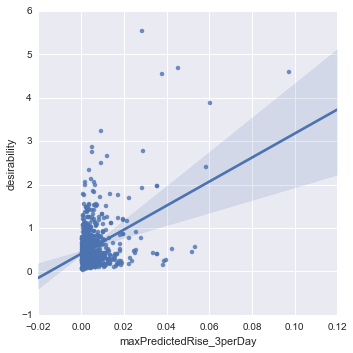

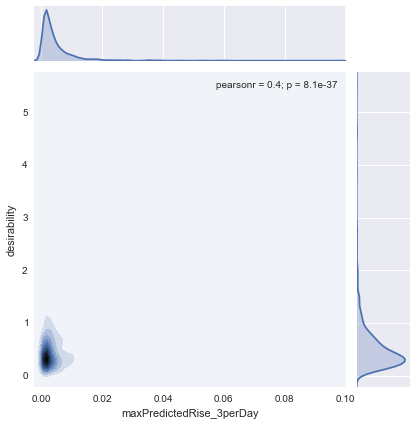

In [227]:
legos["desirability"] = legos["want_it"]/legos["have_it"]

seaborn.lmplot(x="maxPredictedRise_3perDay", y="desirability", data=legos);
seaborn.jointplot(x="maxPredictedRise_3perDay", y="desirability", data=legos, kind="kde");
# print legos['desirability']

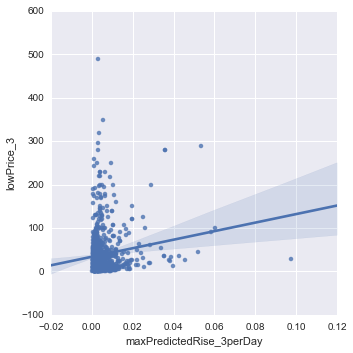

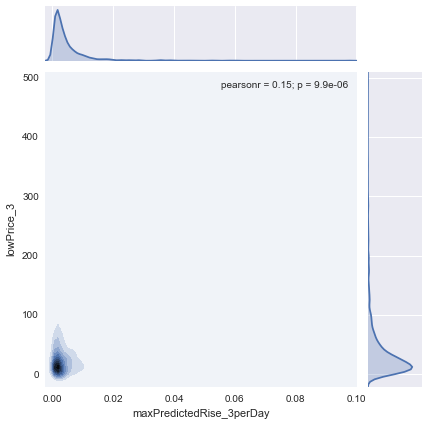

In [228]:
seaborn.lmplot(x="maxPredictedRise_3perDay", y="lowPrice_3", data=legos);
seaborn.jointplot(x="maxPredictedRise_3perDay", y="lowPrice_3", data=legos, kind="kde");

In [229]:
from patsy import dmatrices
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor

## Correct split of training and testing sets, with removing XOR themes
# split data into testing and training sets
cols_to_retain = ['maxPredictedRise_3perDay','desirability','minifigs',
                  'pieces','Theme','avgPrice_3','retailPrice',
                  'time_to_now','want_it']

# Setup all data
legoData = legos[cols_to_retain]

target,features = dmatrices('maxPredictedRise_3perDay ~ desirability+minifigs+pieces+lowPrice_3+avgPrice_3+time_to_now+retailPrice + C(Theme)',legos, return_type='dataframe')
target_train, target_test, features_train, features_test = train_test_split(target, 
                                                            features, test_size = 0.2, random_state=144)

# Support vector regression
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(features_train, np.ravel(target_train))
preds = lr.predict(features_test)
score = lr.score(features_test,np.ravel(target_test))
print score

0.259049724061


In [230]:
from patsy import dmatrices
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor

## Correct split of training and testing sets, with removing XOR themes
# split data into testing and training sets
cols_to_retain = ['maxPredictedRise_3perDay','desirability','minifigs','pieces',
                  'Theme','avgPrice_3','retailPrice',
                  'time_to_now','want_it']

# Setup all data
legoData = legos[cols_to_retain]

target,features = dmatrices('maxPredictedRise_3perDay ~ desirability+minifigs+pieces+avgPrice_3+time_to_now+retailPrice + C(Theme)',legos, return_type='dataframe')
target_train, target_test, features_train, features_test = train_test_split(target, 
                                                            features, test_size = 0.2, random_state=144)

print target_train.shape
print target_test.shape
print features_train.shape
print features_test.shape

####### FITTING
rf = RandomForestRegressor(random_state=144, n_estimators=1000)
rf.fit(features_train, np.ravel(target_train))

preds = rf.predict(features_test)
score = rf.score(features_test,np.ravel(target_test))

(735, 1)
(184, 1)
(735, 74)
(184, 74)


R^2 =0.750914115319
Feature ranking:
('1. feature 72 (0.449035)', 'time_to_now')
('2. feature 71 (0.218508)', 'avgPrice_3')
('3. feature 73 (0.150534)', 'retailPrice')
('4. feature 68 (0.038609)', 'desirability')
('5. feature 5 (0.031741)', 'C(Theme)[T.Batman]')
('6. feature 70 (0.027432)', 'pieces')
('7. feature 52 (0.025682)', 'C(Theme)[T.Sports]')
('8. feature 69 (0.016796)', 'minifigs')
('9. feature 53 (0.014799)', 'C(Theme)[T.Star Wars]')
('10. feature 23 (0.003405)', 'C(Theme)[T.Ideas]')


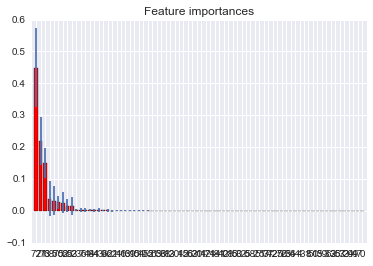

In [231]:
print "R^2 ="+str(score)
# print np.squeeze(preds[:10]), target_test[:10]
# print rf.get_params()
# print rf.feature_importances_

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]),features.columns[indices[f]])
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(74), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(74), indices)
plt.xlim([-1, 74])
plt.show()